This file is for exploration and experimentation for checking if the various aspects of the project would work

In [6]:
import pandas as pd
import numpy as np
import os
import networkx as nx
import torch
# from tqdm import tqdm
import geopandas as gpd
import shapely as geom
from shapely.geometry import Point, LineString
# import plotly.graph_objects as go

# Trying to create the L stations graph

In [7]:
# loading the shapefile
stations = gpd.read_file("data/l_stations/CTA_RailStations.shp")
rails = gpd.read_file("data/l_lines/geo_export_717b00c4-60f6-4164-86a6-4a25f7d068de.shp")

c:\Users\danie\anaconda3\envs\torchfix\lib\site-packages\pyogrio\core.py:35: RuntimeWarning: Could not detect GDAL data files.  Set GDAL_DATA environment variable to the correct path.
  _init_gdal_data()


In [8]:
print(stations.crs)
print(rails.crs)

EPSG:3435
EPSG:4326


In [10]:
rails.head()

,lines,descriptio,type,legend,shape_len,geometry
0,"Brown, Orange, Pink, Purple (Express)",Tower 12 to Library,Elevated or At Grade,ML,647.793225,"LINESTRING (-87.62821 41.87691, -87.62757 41.8..."
1,"Brown, Purple",Subway Portal B to Sedgwick,Elevated or At Grade,BR,4303.794929,"LINESTRING (-87.6393 41.91041, -87.63975 41.91..."
2,Yellow Line,Oakton-Skokie to Howard,Elevated or At Grade,YL,21195.444430,"LINESTRING (-87.7472 42.02619, -87.7471 42.025..."
3,"Brown, Green, Orange, Pink, Purple (Exp)",Washington/Wabash to Adams/Wabash,Elevated or At Grade,ML,1352.120554,"LINESTRING (-87.6261 41.87951, -87.62616 41.88..."
4,"Brown, Green, Orange, Pink, Purple (Exp)",State/Lake to Washington/Wabash,Elevated or At Grade,ML,1317.604924,"LINESTRING (-87.62619 41.88322, -87.62626 41.8..."


Changing to EPSG:26916

In [7]:
stations = stations.to_crs(epsg=26916)
rails = rails.to_crs(epsg=26916)

In [38]:
stations.columns, rails.columns

(Index(['STATION_ID', 'LONGNAME', 'LINES', 'ADDRESS', 'ADA', 'PKNRD', 'POINT_X',
        'POINT_Y', 'geometry'],
       dtype='object'),
 Index(['lines', 'descriptio', 'type', 'legend', 'shape_len', 'geometry'], dtype='object'))

In [39]:
stations.head(1)

,STATION_ID,LONGNAME,LINES,ADDRESS,ADA,PKNRD,POINT_X,POINT_Y,geometry
0,230,Cumberland,Blue Line,5800 N. Cumberland Avenue,1,1,1.118914e+06,1.937256e+06,POINT (430579.352 4648372.031)


In [40]:
[i for i in stations['LONGNAME'].values if i.startswith("Roosevelt")]

['Roosevelt/Wabash', 'Roosevelt/State']

In [8]:
[i for i in rails['descriptio'].values if i.startswith("Roosevelt")]

['Roosevelt/Wabash to Tower 12', 'Roosevelt/State to Harrison']

Create a graph

In [41]:
G = nx.Graph()

# Add all stations as nodes
for idx, row in stations.iterrows():
    G.add_node(row['LONGNAME'], pos=(row.geometry.x, row.geometry.y))

So the commented code below does not give very accurate edges, example: for green line, there is no edge from Roosevelt to Adams/Wabash, which exists in the green line.

In [11]:
rails.head()

,lines,descriptio,type,legend,shape_len,geometry
0,"Brown, Orange, Pink, Purple (Express)",Tower 12 to Library,Elevated or At Grade,ML,647.793225,"LINESTRING (-87.62821 41.87691, -87.62757 41.8..."
1,"Brown, Purple",Subway Portal B to Sedgwick,Elevated or At Grade,BR,4303.794929,"LINESTRING (-87.6393 41.91041, -87.63975 41.91..."
2,Yellow Line,Oakton-Skokie to Howard,Elevated or At Grade,YL,21195.444430,"LINESTRING (-87.7472 42.02619, -87.7471 42.025..."
3,"Brown, Green, Orange, Pink, Purple (Exp)",Washington/Wabash to Adams/Wabash,Elevated or At Grade,ML,1352.120554,"LINESTRING (-87.6261 41.87951, -87.62616 41.88..."
4,"Brown, Green, Orange, Pink, Purple (Exp)",State/Lake to Washington/Wabash,Elevated or At Grade,ML,1317.604924,"LINESTRING (-87.62619 41.88322, -87.62626 41.8..."


In [42]:
def nearest_station(point, stations_gdf):
    # returns the nearest station name to a point
    distances = stations_gdf.geometry.distance(point)
    return stations_gdf.iloc[distances.idxmin()]['LONGNAME']

for idx, row in rails.iterrows():
    line_geom = row.geometry
    if line_geom.geom_type == 'MultiLineString':
        line_geom = max(line_geom, key=lambda l: l.length)

    # Get start and end points of the line
    start_point = Point(line_geom.coords[0])
    end_point = Point(line_geom.coords[-1])

    s1 = nearest_station(start_point, stations)
    s2 = nearest_station(end_point, stations)

    if s1 != s2:
        G.add_edge(s1, s2)


Visualizing the graph

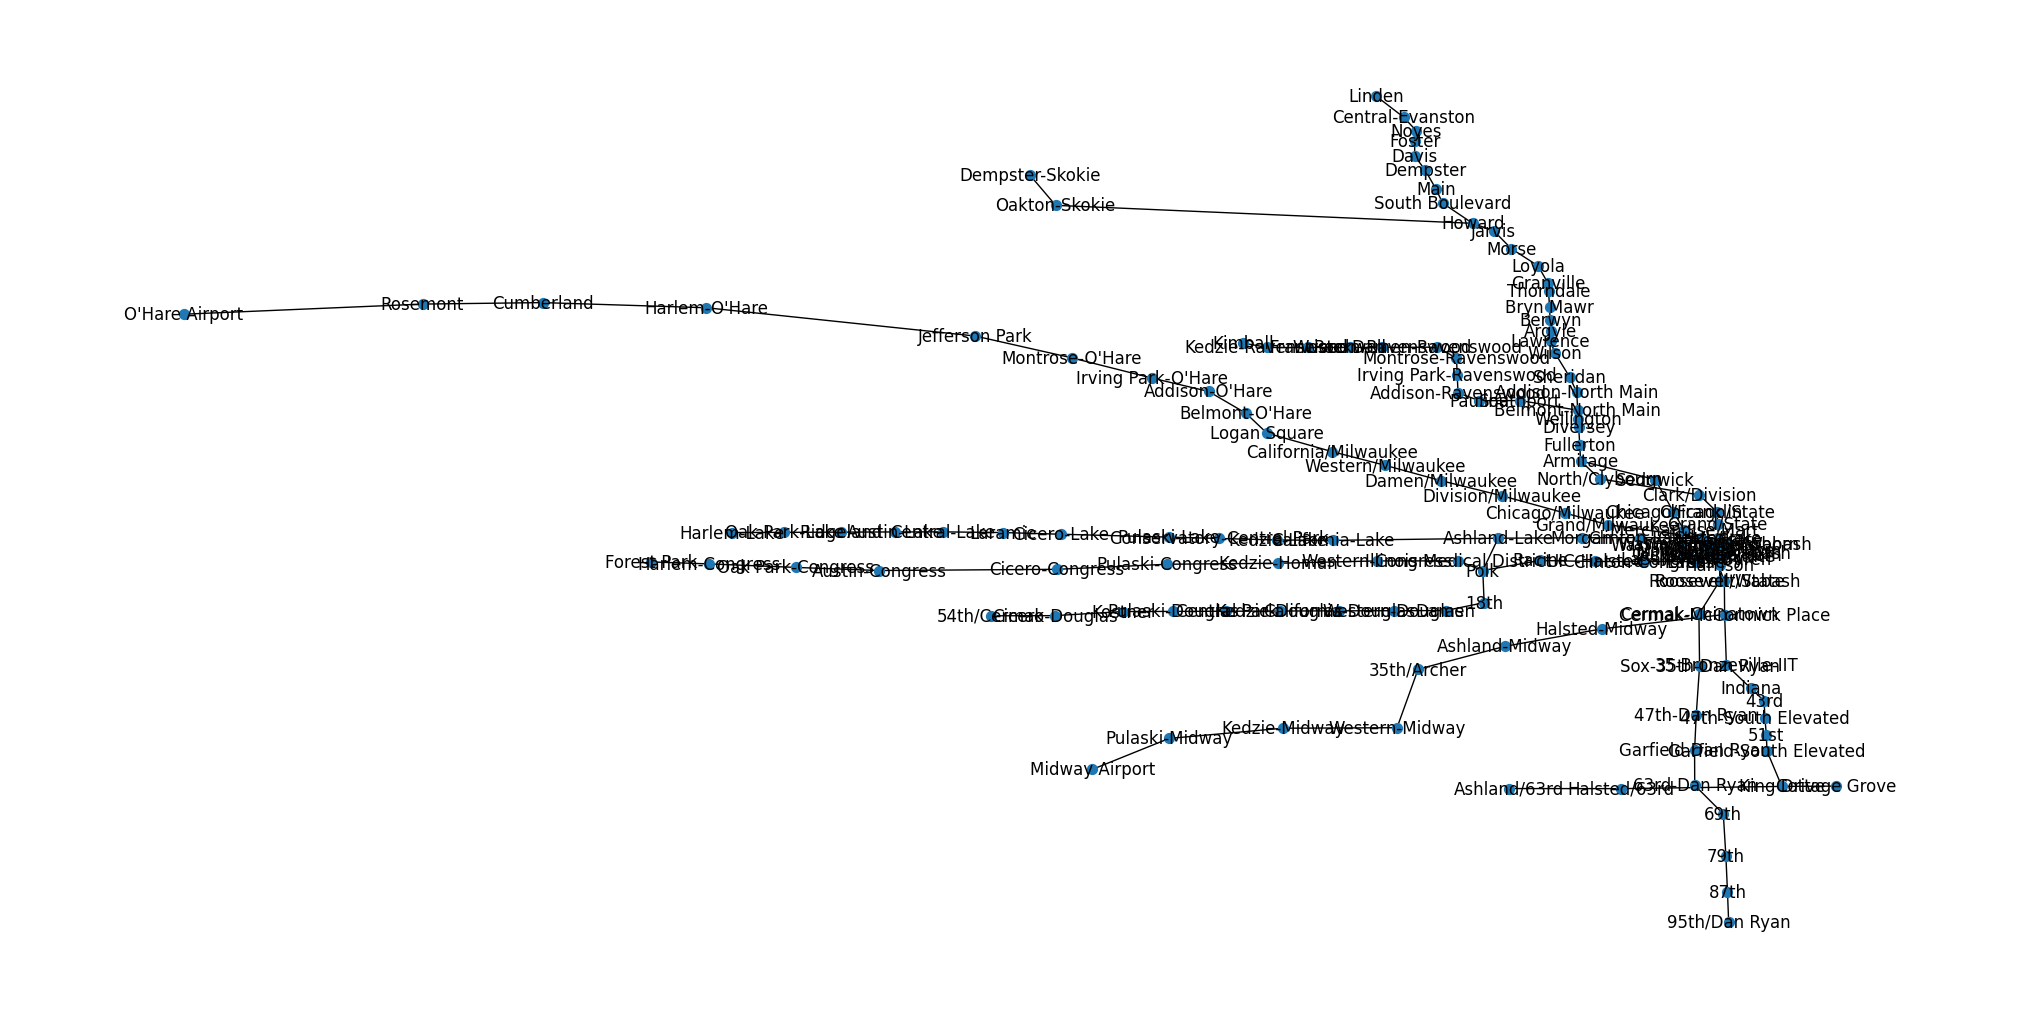

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_size=50)
plt.show()

In [44]:
node_x = []
node_y = []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

In [45]:
cmap = {
    'Blue Line':'#0AA7E0',
    'Green Line (Lake)': "#1EDB37",
    'Green (Lake), Pink': "#0B2B03",
    "Blue Line (O'Hare)": "#044E69",
    'Brown, Purple (Express)': "#331406",
    'Brown Line': "#532A04",
    'Brown, Orange, Pink, Purple (Express)': "#2A0481",
    'Brown, Orange, Pink,  Purple (Express), Green': "#2A0481",
    'Red Line': "#DA0A0A",
    'Green Line': "#1CE00A",
    'Green Line (Englewood)': "#1CE00A",
    'Orange & Green Lines': "#E0830A",
    'Red, Brown, Purple (Express)': "#550303",
    'Purple Line, Evanston Express': "#2A0481",
    'Red, Yellow, Purple, Evanston Express': "#321D64",
    'Yellow Line': "#BDBA0B",
    'Blue Line (Congress)': "#5FBAE4",
    'Orange Line': "#C56D09",
    'Pink': "#7D0481",
     'Purple, Red Line': "#410E63",
    'Brown, Orange, Pink, Purple (Express), Green, Blue': "#523509"
}

In [46]:
# creating a line color
line_color = stations['LINES'].map(lambda l: cmap[l])

In [47]:
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=line_color,
        size=10,
        colorbar=dict(
            thickness=15,
            title=dict(
              text='Node Connections',
              side='right'
            ),
            xanchor='left',
        ),
        line_width=2),
      text=stations['LONGNAME'])

In [48]:
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

In [49]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title=dict(
                    text="CTA L-Graph",
                    font=dict(
                        size=16
                    )
                ),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
    plot_bgcolor='white',
)
fig.show()

### Get an adjacency matrix for G

In [50]:
cta_adj_mat = nx.adjacency_matrix(G)
cta_adj_mat = cta_adj_mat.toarray()

In [54]:
adj_df = pd.DataFrame(cta_adj_mat, columns = G.nodes(), index=G.nodes())

In [55]:
adj_df.head()

,Cumberland,Oak Park-Lake,Austin-Lake,Ashland-Lake,Clinton-Lake,Grand/Milwaukee,Chicago/Milwaukee,Damen/Milwaukee,California/Milwaukee,Belmont-O'Hare,...,Southport,Adams/Wabash,Jackson/State,Rosemont,Harlem-Lake,Division/Milwaukee,95th/Dan Ryan,63rd-Dan Ryan,Garfield-Dan Ryan,Roosevelt/State
Cumberland,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
Oak Park-Lake,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
Austin-Lake,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ashland-Lake,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Clinton-Lake,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# saving
adj_df.to_csv('data/graph/adj_mat.csv')

In [66]:
# saving this
import pickle
with open('data/graph/cta_adj_mat_tofix.pkl', 'wb') as f:
    pickle.dump(cta_adj_mat, f)

# Fixing the inconsistencies in the dataframe

In [16]:
# loading the intermediate adjacency matrix
adj_df = pd.read_csv('data/graph/cta_adj_mat_inter.csv', index_col='Unnamed: 0')
print(adj_df.shape)
adj_df.head()

(144, 144)


,Cumberland,Oak Park-Lake,Austin-Lake,Ashland-Lake,Clinton-Lake,Grand/Milwaukee,Chicago/Milwaukee,Damen/Milwaukee,California/Milwaukee,Belmont-O'Hare,...,Southport,Adams/Wabash,Jackson/State,Rosemont,Harlem-Lake,Division/Milwaukee,95th/Dan Ryan,63rd-Dan Ryan,Garfield-Dan Ryan,Roosevelt/State
Cumberland,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
Oak Park-Lake,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
Austin-Lake,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ashland-Lake,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Clinton-Lake,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
adj_df.loc['Sedgwick', ['Chicago/Franklin', 'Armitage']]

NameError: name 'adj_df' is not defined

In [3]:
# total number of connections from the node
adj_df.loc["Ashland/Lake"].sum()

NameError: name 'adj_df' is not defined

In [239]:
# if there are extras connected, checking which they are
adj_df.columns[adj_df.loc[("Wilson")]==1]

Index(['Lawrence', 'Belmont-North Main', 'Howard', 'Sheridan'], dtype='object')

In [233]:
# removing the extra connections
adj_df.loc['Wilson', 'Belmont-North Main'] = 1
# adj_df.loc['Washington/Wells', 'Clinton-Lake'] = 1

In [231]:
# if there are extras connected, checking which they are
adj_df.columns[adj_df.loc[("Belmont-North Main")]==1]

Index(['Wellington', 'Fullerton', 'Wilson', 'Addison-North Main', 'Southport'], dtype='object')

In [111]:
stations.LONGNAME.nunique(), stations.shape

(144, (144, 9))

In [104]:
adj_df.columns[adj_df.loc['Damen']==1], adj_df.columns[adj_df.loc['Damen/Milwaukee']==1], adj_df.columns[adj_df.loc['Damen-Ravenswood']==1]

(Index(['18th', 'Western-Douglas'], dtype='object'),
 Index(['Western/Milwaukee', 'Division/Milwaukee'], dtype='object'),
 Index(['Western-Ravenswood', 'Montrose-Ravenswood'], dtype='object'))

In [408]:
# DONT RUN
# saving the intermediate adjacency matrix
adj_df.to_csv('data/graph/cta_adj_mat_inter.csv')

## Important things to note:
- The L has 146 stations in total, but the shapefile has only 144.
- So far, I have found Damen on the green line to be missing.
    - Actually, on secodn thought, adding Damen might be a good idea because its a newly added station & I can predict for it.
        - By the name: Damen-Cermak (Change it to Damen-Lake, -Cermak suffix is used for pink line stations.)
- Second needs to be found out.
- I am only taking the stations that exist in the shapefiles.
- Library and Jackson/Dearborn and Jackson/State stations are connected using walkways, but not using a rail connection. Therefore, even though they are so close and form an interchange, I am not going to connect them in the graphs, the graphs will only contain connections where stations are connected via a physical railway connection.
- NOTE TO SELF: Chicago/state is the red line, Chicago/Milwaukee is the blue line.

### Edge Fixes

- There are two stations in the shapefiles, Lake/State and State/Lake. Theyre they close by stations the loop, with State/Lake being the station in the loop with mutliple lines running through it while the Lake/State being the Lake station in the red line. Since theyre so close, and are part of the same 'larger' station, the multimodal and other datapoins collected for them will be same.
- King Drive has an incorrect connection to Halsted/63rd in the Green Line. This connection does not exist in reality, so I am removing this[DONE].
    - Remember to remove this connection from Halsted/63rd and fix it.[DONE]
    - At the same time, Garfield-South Elevated (Garfield Green Line) should be connected to King Drive and Halsted/63rd (for green Line). [Done]
- Roosevelt/Wabash is the green and orange line part of the roosevelt station, and roosevelt/state is for the red line. Theyre the same station in reality, but in the shapefile, theyre mentioned to be different. I will need to combine them into one (ill do this later).
    - Also, in the current shapefile, Roosevelt/Wabash is not connected to Adams/Wabash and Halsted-Midway. I need to add those connections. [DONE]
    - At the same time, Ashland-Midway is connected to Cermak-McCormick Place instead of Roosevelt/Wabash. Need to fix it. [DONE]
    - I also need to remove that connection from Cermak-McCormick Place's connections. [DONE]
- For the Belmont-North Main (the belomnt station in red, purple and brown lines), two connections are missing.
    - I need to add wilson (purple express line) [DONE]
    - I need to add Fullerton (Red line) [DONE]
    - For both of them, I need to make sure that theyre also connected to Belmont-North Main in reverse. [BOTH DONE]
- The North/Clybourn red line station is incorrectly connected to Armitage, I need to correct this connection to Fullerton.
    - Also need to make sure that this connection is updated for Fulelrton too. [DONE]
- The Racine Blue line station is connected to Polk (pink line) and not to Illinois Medical District. Need to correct that. [Done]
    - Need to update connections for polk and Illinois Medical District. [BOTH DONE]
- Fixed Clinton-Lake, Merchandise Mart, Washington/Wells: Basically, they did not have all the connections, due to being just outside, or connected with stations outside the loop. [DONE]
- Added Washington/Wabash (Washington Green line) to Adams/Wabash, which was missing. [DONE]
- I might need to rename/combine Monroe, Washington, Jackson etc (if they dont have the commuter counts).

__The adjacency matrix is fixed....Saving it finally.__

In [242]:
adj_df.to_csv('data/graph/cta_adj_mat_final.csv')

Testing with a graph.

In [254]:
G2 = nx.from_pandas_adjacency(adj_df)

In [255]:
[i for i in G2.nodes() if i not in stations.LONGNAME.values]

[]

In [256]:
len(G2.nodes())

144

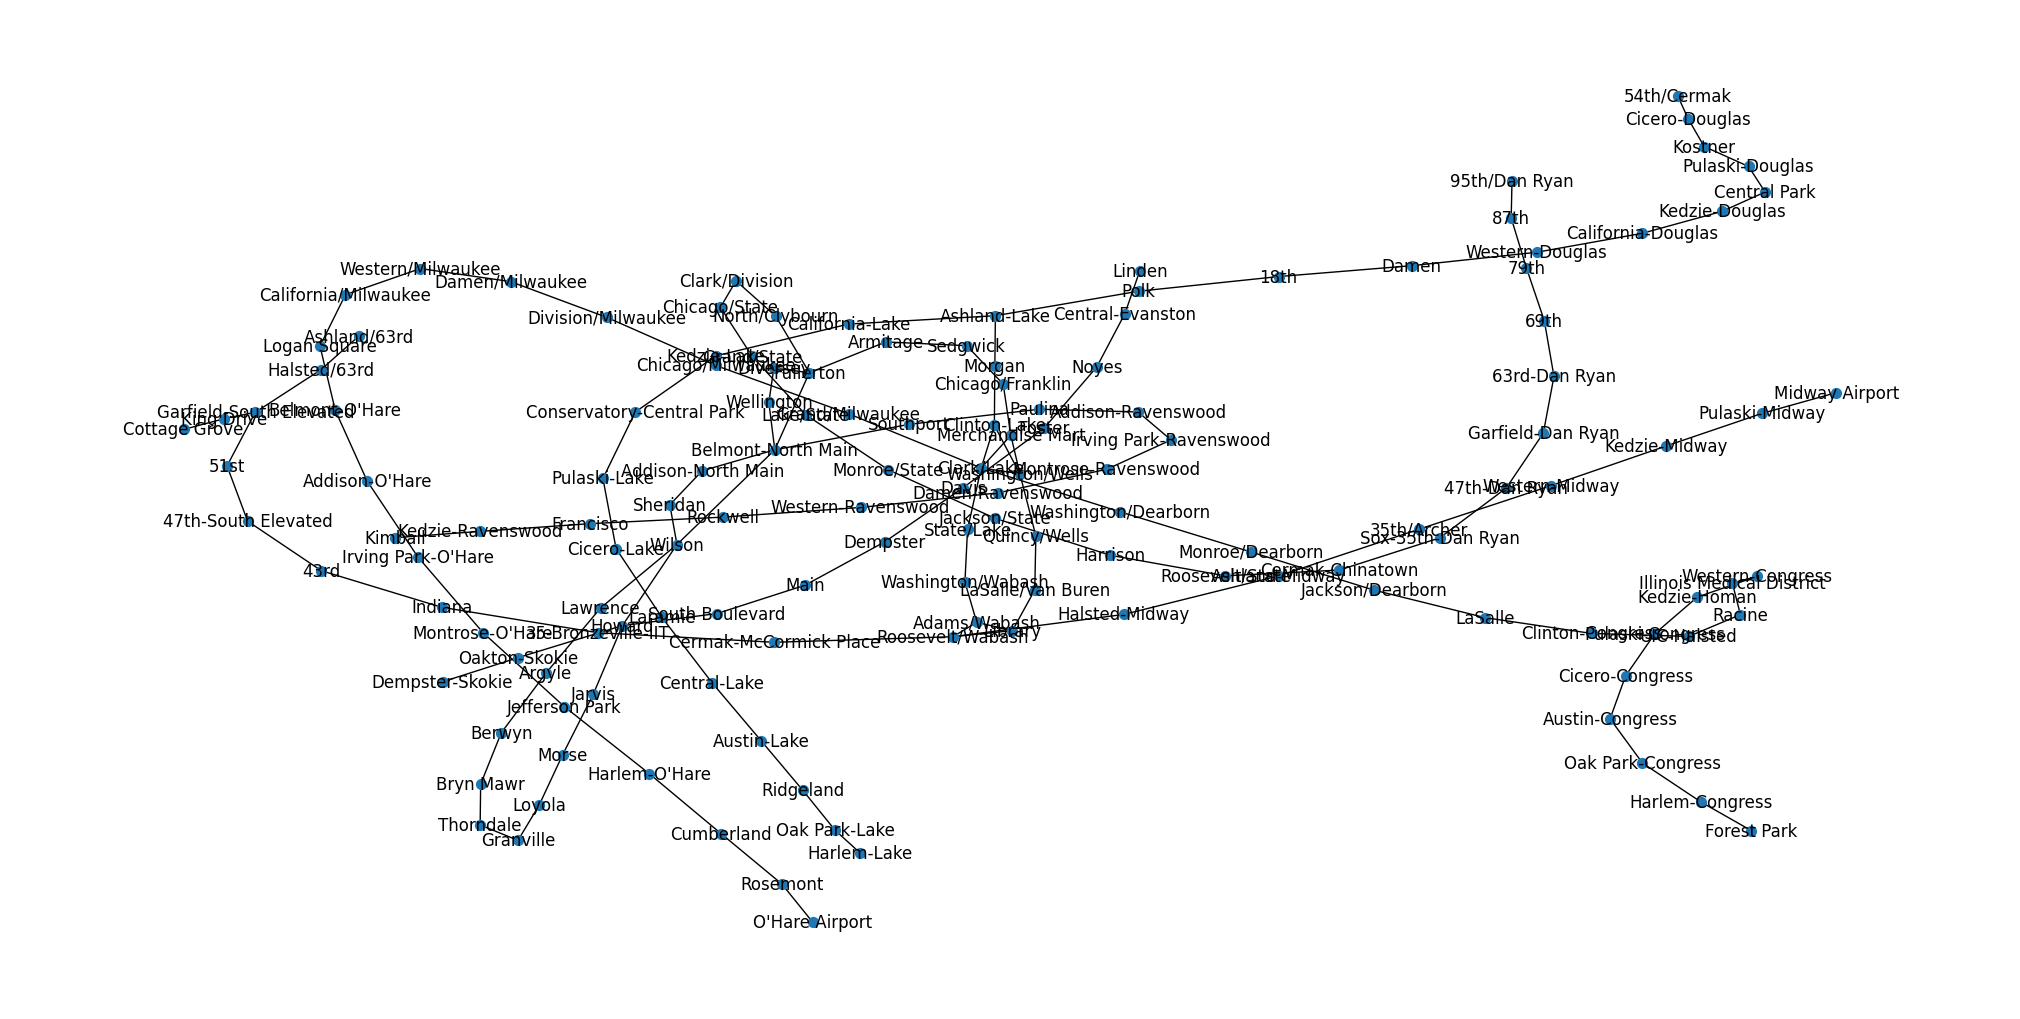

In [257]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
# pos = nx.get_node_attributes(G2, 'pos')
nx.draw(G2, with_labels=True, node_size=50)
plt.show()

# IGNORE STUFF BELOW, IT WAS ME FRANTICALLY TRYING TO FIX THE GRAPH, BUT INSTEAD DOING IT MANUALLY WILL BE FASTER AND EASIER.

The graph gives an error that the node Tower12 has no position. Why is that?

In [89]:
# checking if tower 12 should even be a valid node
'Tower 12' in stations["LONGNAME"]

False

So, Tower 12 does not even exist, Maybe I need to place a check to remove any edges with stations that do not exist in the edges.

In [105]:
for e in edges:
    if (e[0] not in stations['LONGNAME']) or (e[1] not in stations['LONGNAME']):
        edges.remove(e)
    # if e[1] not in stations['LONGNAME']:
    #     edges.remove(e)

len(edges)

76

In [106]:
for e in edges:
    G.add_edge(e[0], e[1])

NetworkXError: Node 'Subway Portal B' has no position.

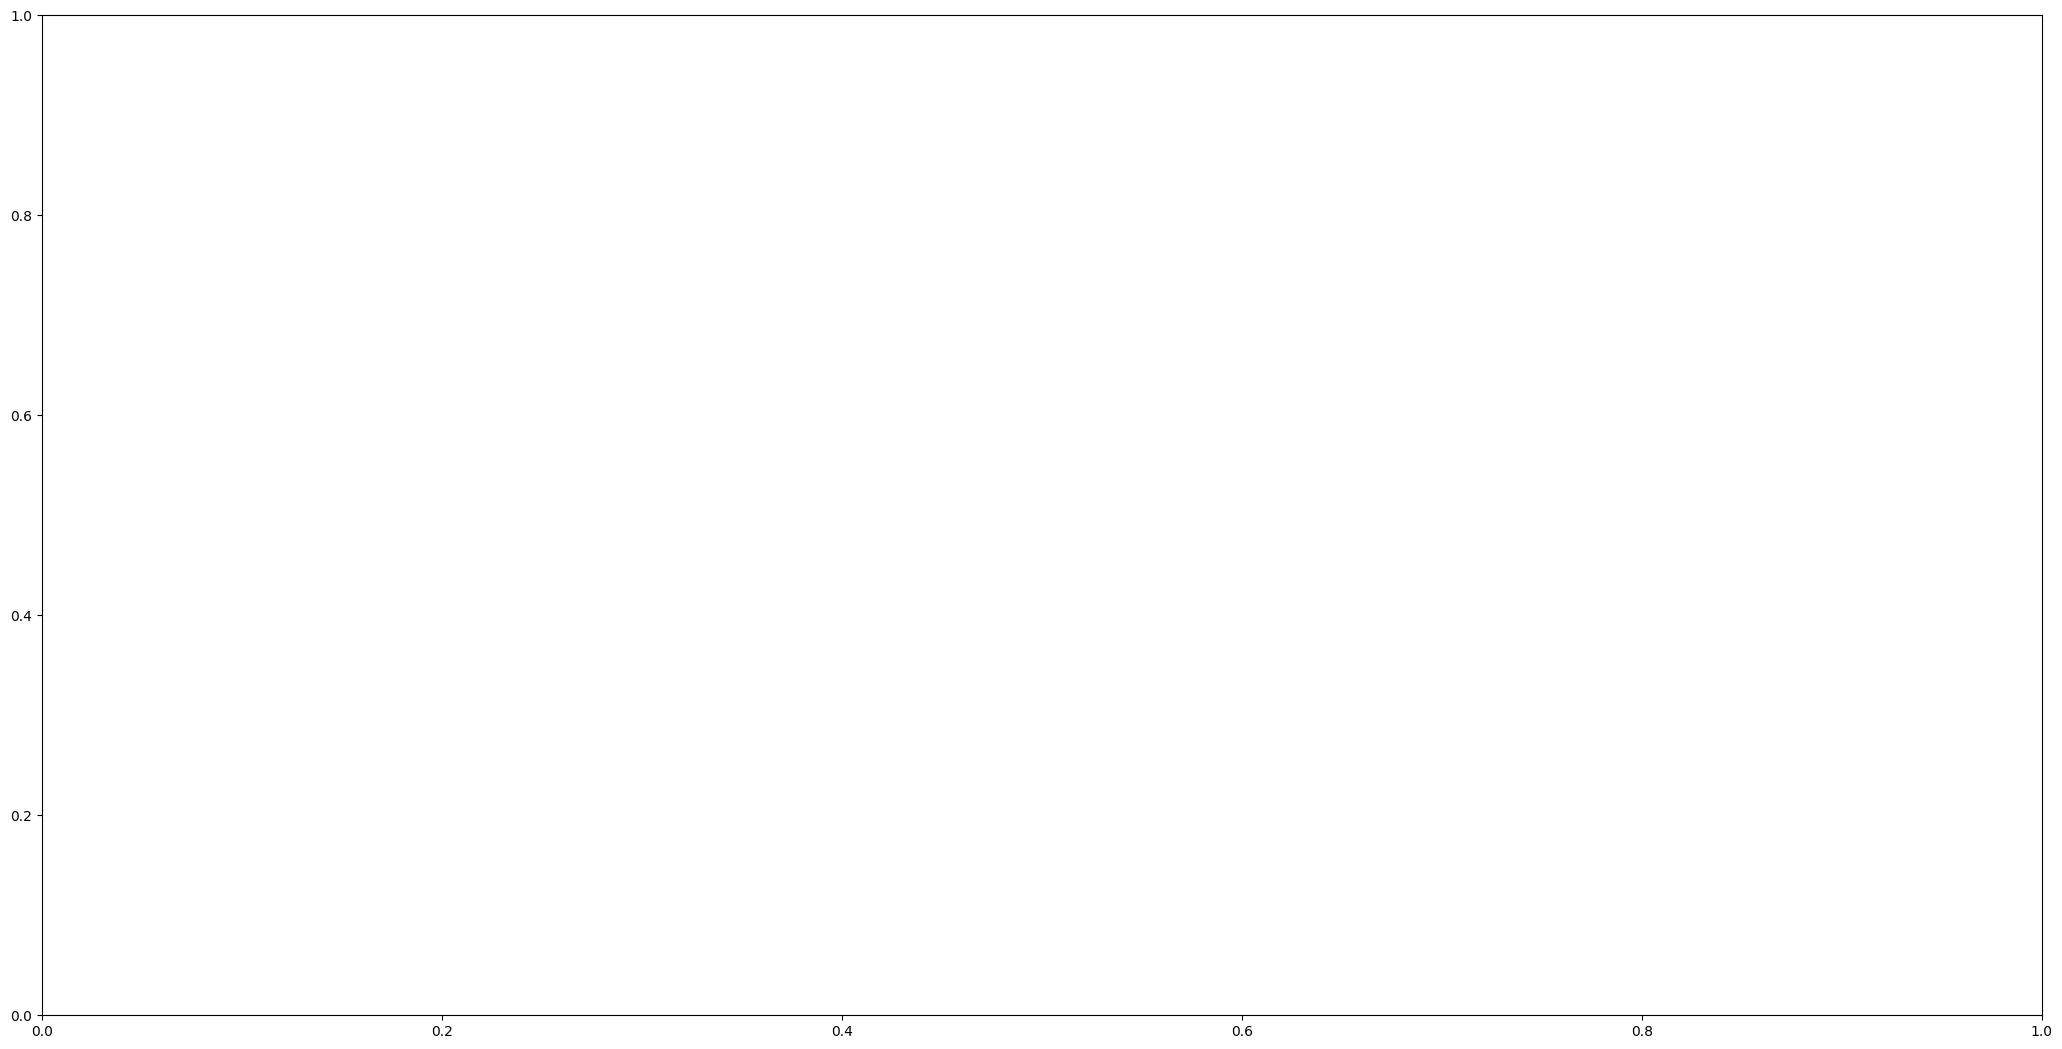

In [107]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_size=50)
plt.show()

Issue with this is that it seems that some of the connections might be incorrect. For example, there is a connection between Roosevelt and Adams/Wabash in green line which does not appear here.

In [17]:
stations.head()

,STATION_ID,LONGNAME,LINES,ADDRESS,ADA,PKNRD,POINT_X,POINT_Y,geometry
0,230,Cumberland,Blue Line,5800 N. Cumberland Avenue,1,1,1.118914e+06,1.937256e+06,POINT (430579.352 4648372.031)
1,1350,Oak Park-Lake,Green Line (Lake),100 S. Oak Park Avenue,0,0,1.131166e+06,1.901870e+06,POINT (434144.327 4637533.292)
2,1260,Austin-Lake,Green Line (Lake),351 N. Austin Blvd,0,0,1.136515e+06,1.902016e+06,POINT (435774.735 4637552.292)
3,170,Ashland-Lake,"Green (Lake), Pink",1601 W. Lake Street,1,0,1.165707e+06,1.901502e+06,POINT (444665.5 4637257.634)
4,1160,Clinton-Lake,"Green (Lake), Pink",540 W. Lake Street,1,0,1.172562e+06,1.901699e+06,POINT (446754.898 4637285.23)


In [18]:
rails.head()

,lines,descriptio,type,legend,shape_len,geometry
0,"Brown, Orange, Pink, Purple (Express)",Tower 12 to Library,Elevated or At Grade,ML,647.793225,"LINESTRING (447872.951 4636300.41, 447926.239 ..."
1,"Brown, Purple",Subway Portal B to Sedgwick,Elevated or At Grade,BR,4303.794929,"LINESTRING (446980.193 4640026.723, 446943.368..."
2,Yellow Line,Oakton-Skokie to Howard,Elevated or At Grade,YL,21195.444430,"LINESTRING (438143.857 4652954.313, 438152.22 ..."
3,"Brown, Green, Orange, Pink, Purple (Exp)",Washington/Wabash to Adams/Wabash,Elevated or At Grade,ML,1352.120554,"LINESTRING (448050.245 4636588.009, 448047.451..."
4,"Brown, Green, Orange, Pink, Purple (Exp)",State/Lake to Washington/Wabash,Elevated or At Grade,ML,1317.604924,"LINESTRING (448045.709 4636999.953, 448041.792..."


In [20]:
line_desc = rails['descriptio'].unique()
line_desc

array(['Tower 12 to Library', 'Subway Portal B to Sedgwick',
       'Oakton-Skokie to Howard', 'Washington/Wabash to Adams/Wabash',
       'State/Lake to Washington/Wabash', 'Clark/Lake to State/Lake',
       'Kedzie-Ravenswood to Francisco', 'Rockwell to Western-Ravenswood',
       'Damen-Ravenswood to Montrose-Ravenswood',
       'Addison-Ravenswood to Paulina', 'Paulina to Southport',
       'Harlem-Lake to Oak Park-Lake', 'Austin-Lake to Central-Lake',
       'Laramie to Cicero-Lake',
       'Pulaski-Lake to Conservatory-Central Park',
       'Conservatory-Central Park to Kedzie-Lake',
       'Cottage Grove to King Drive', 'Garfield-South Elevated to 51st',
       '47th-South Elevated to 43rd', 'Indiana to 35-Bronzeville-IIT',
       'Midway Airport to Pulaski-Midway',
       'Monroe/State to Jackson/State', 'Lake/State to Monroe/State',
       'Pulaski-Congress to Kedzie-Homan',
       'Illinois Medical District to Loomis Junction',
       'Rosemont to Cumberland', '95/Dan Ryan to

In [40]:
len(edges)

153